You need to install opencv python library first by: pip install opencv-contrib-python if you do not have it on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import cv2
import glob
import h5py
from skimage.morphology import disk
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
%matplotlib inline 

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
# for plot figures
plt.rcParams['svg.fonttype'] = 'none'
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [3]:
movie_name = "movie_bgr_20180713_05_real.h5"

#analysis unit: could be one region, region list, one frame or frame list
#frame_num: list of frame numbers to be used
#frame region to be used: [x1:x2,y1:y2] (x1 x2 in height direction, y1 y2 in width direction)
def analysis_units_fun(frame_num,x1,x2,y1,y2):
    return movie_bgr_h5[frame_num,x1:x2,y1:y2,:]

In [4]:
#import data
def read_movie_from_h5(filename):
    h5f = h5py.File(filename,'r')
    movie_bgr_h5=h5f['movie_bgr_real'][:]
    h5f.close()
    return movie_bgr_h5
movie_bgr_h5=read_movie_from_h5(movie_name) 
print (movie_bgr_h5.shape)

(1936, 437, 437, 3)


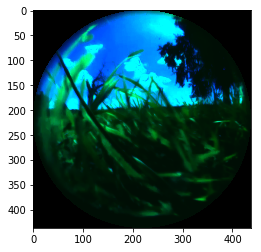

In [6]:
#show one example, image real value
plt.imshow(movie_bgr_h5[1500][...,::-1])

In [7]:
#to better visulaize image, use gamma correction to transfer image real to image view
def img_real2view(img):
    gamma_correction=lambda x:np.power(x,1.0/2.2)
    img_shape=img.shape
    # gray image
    if np.size(img_shape)==2:
        #uint8
        if np.max(img)>1:
            temp_view=np.zeros_like(img,dtype=np.float32)
            temp_view=np.float32(img)/255.0#float32, 1.0
            temp_view=gamma_correction(temp_view)
            temp_view2=np.zeros_like(img,dtype=np.uint8)
            temp_view2=np.uint8(temp_view*255)
            return temp_view2
        #float
        if np.max(img)<2:
            return gamma_correction(img)
    #color image
    if np.size(img_shape)==3:
        #uint8
        if np.max(img)>1:
            temp_view=np.zeros_like(img,dtype=np.float32)
            temp_view=np.float32(img)/255.0#1.0
            temp_view=gamma_correction(temp_view)
            temp_view2=np.zeros_like(img,dtype=np.uint8)
            temp_view2=np.uint8(temp_view*255)#255
            return temp_view2
        #float
        if np.max(img)<2:
            return gamma_correction(img)


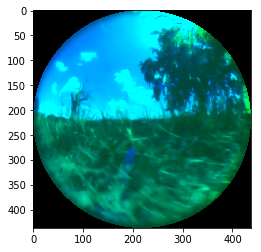

In [8]:
#show one example, image view value
plt.imshow(img_real2view(movie_bgr_h5[1080])[...,::-1])

### Intensity Distribution along Altitude
For each elevation, 
1. get all the values of that elevation in all frams for both UV and green channels
2. calculate the median value of all values for UV and green channels, respectively
3. calculate the 25 percentile value of all values for UV and green channels, respectively
4. calculate the 75 percentile value of all values for UV and green channels, respectively

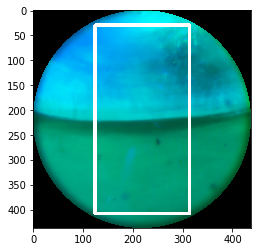

In [9]:
#average over all images in this movie
movie_mean=np.uint8(np.mean(movie_bgr_h5,axis=0))
squ_mean_draw=np.copy(img_real2view(movie_mean))
cv2.rectangle(squ_mean_draw,(124,30),(313,407),color=(255,255,255),thickness=5)
plt.imshow(squ_mean_draw[...,::-1])

In [10]:
ver_all=np.float32(analysis_units_fun(np.arange(len(movie_bgr_h5)),30,407,124,313)[...,::-1]/255.0)
ver_all=np.transpose(ver_all,(1,0,2,3))
ver_all_UV=ver_all[...,-1]
ver_all_G=ver_all[...,1]
ver_all_UV=np.reshape(ver_all_UV,(377,-1))
ver_all_G=np.reshape(ver_all_G,(377,-1))
ver_UV_median=np.median(ver_all_UV,axis=1)[::-1]
ver_G_median=np.median(ver_all_G,axis=1)[::-1]
ver_UV_25p=np.percentile(ver_all_UV,25,axis=1)[::-1]
ver_G_25p=np.percentile(ver_all_G,25,axis=1)[::-1]
ver_UV_75p=np.percentile(ver_all_UV,75,axis=1)[::-1]
ver_G_75p=np.percentile(ver_all_G,75,axis=1)[::-1]
ver_axis=np.linspace(-75,75,len(ver_UV_median))

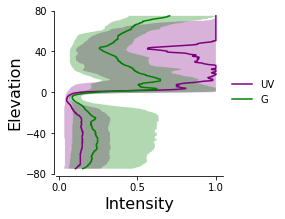

In [11]:
#plot, intensity Distribution along Altitude
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.plot(ver_UV_median,ver_axis,color='purple',label='UV')
ax.fill_betweenx(ver_axis,ver_UV_25p,ver_UV_75p,facecolor='purple', alpha=0.3)
ax.plot(ver_G_median,ver_axis,color='g',label='G')
ax.fill_betweenx(ver_axis,ver_G_25p,ver_G_75p,facecolor='green', alpha=0.3)
adjust_spines(ax, ['left', 'bottom'])
ax.set_xticks([0,0.5,1])
ax.set_yticks([-80,-40,0,40,80])
ax.set_ylim([-80,80])
ax.set_xlabel('Intensity', fontsize=16)
ax.set_ylabel('Elevation', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))

### color histogram

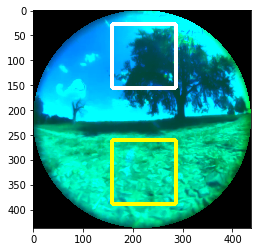

In [12]:
#color histogram
col_his_draw=np.copy(img_real2view(movie_bgr_h5[0]))
x1,x2,y1,y2=28,28+128,158,158+128
cv2.rectangle(col_his_draw,(y1,x1),(y2,x2),color=(255,255,255),thickness=5)
x1,x2,y1,y2=260,260+128,158,158+128
cv2.rectangle(col_his_draw,(y1,x1),(y2,x2),color=(0,255,255),thickness=5)
plt.imshow(col_his_draw[...,::-1])

In [13]:
#upper
x1,x2,y1,y2=28,28+128,158,158+128
thresh=[0,0.3]

def fratio_darkbright(img_bgr):
    temp=img_bgr[...,:2].reshape(-1,2)
    ratio_dark  =len(np.where((temp[...,0]<6)|(temp[...,1]<15))[0])/len(temp)
    ratio_bright=len(np.where((temp[...,0]>254)|(temp[...,1]>254))[0])/len(temp)
    return ratio_dark+ratio_bright
#
ratio_darkbright=np.zeros((len(movie_bgr_h5)))
for ii in range(len(ratio_darkbright)):
    temp=movie_bgr_h5[ii,x1:x2,y1:y2,:]
    ratio_darkbright[ii]=fratio_darkbright(temp)

temps=[]
tempind=np.where((ratio_darkbright>=thresh[0])&(ratio_darkbright<=thresh[1]))[0]
temp   =movie_bgr_h5[tempind,x1:x2,y1:y2,:]
col_all_dview=np.array(temp) 
print (col_all_dview.shape)
col_all_dview=np.reshape(col_all_dview[...,:2],(-1,2))
print (col_all_dview.shape)
num=50000
np.random.seed(6)
temp=np.random.choice(len(col_all_dview),num,replace=False)
col_all_dview=col_all_dview[temp]
print (col_all_dview.shape)

(384, 128, 128, 3)
(6291456, 2)
(50000, 2)


In [14]:
#lower
x1,x2,y1,y2=260,260+128,158,158+128
ratio_darkbright=np.zeros((len(movie_bgr_h5)))
for ii in range(len(ratio_darkbright)):
    temp=movie_bgr_h5[ii,x1:x2,y1:y2,:]
    ratio_darkbright[ii]=fratio_darkbright(temp)

temps=[]
tempind=np.where((ratio_darkbright>=thresh[0])&(ratio_darkbright<=thresh[1]))[0]
temp   =movie_bgr_h5[tempind,x1:x2,y1:y2,:]
col_all_vview=np.array(temp) 
print (col_all_vview.shape)
col_all_vview=np.reshape(col_all_vview[...,:2],(-1,2))
print (col_all_vview.shape)
num=50000
np.random.seed(66)
temp=np.random.choice(len(col_all_vview),num,replace=False)
col_all_vview=col_all_vview[temp]
print (col_all_vview.shape)

(1741, 128, 128, 3)
(28524544, 2)
(50000, 2)


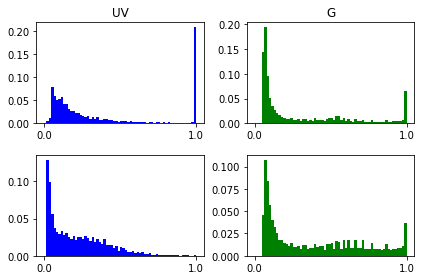

In [15]:
#1D histogram
weights = np.ones_like(col_all_dview[...,-1].flatten())/float(len(col_all_dview[...,-1].flatten()))
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0,0].hist(col_all_dview[...,0].flatten(), bins=64,color='b',range=[0,255],weights=weights)
axes[0,0].set_title('UV'),
labels = ['0.0','1.0']
axes[0,0].set_xticks([0,255]),axes[0,0].set_xticklabels(labels)
axes[0,1].hist(col_all_dview[...,1].flatten(), bins=64,color='g',range=[0,255],weights=weights)
axes[0,1].set_title('G')
axes[0,1].set_xticks([0,255]),axes[0,1].set_xticklabels(labels)
axes[1,0].hist(col_all_vview[...,0].flatten(), bins=64,color='b',range=[0,255],weights=weights)
axes[1,0].set_xticks([0,255]),axes[1,0].set_xticklabels(labels)
axes[1,1].hist(col_all_vview[...,1].flatten(), bins=64,color='g',range=[0,255],weights=weights)
axes[1,1].set_xticks([0,255]),axes[1,1].set_xticklabels(labels)
plt.tight_layout()

In [16]:
#2D histogram
weights = np.ones_like(col_all_dview[...,-1].flatten())/float(len(col_all_dview[...,-1].flatten()))
H_dview, _, _ = np.histogram2d(col_all_dview[...,0].flatten(), \
                               col_all_dview[...,1].flatten(), \
                               bins=64,range=[[0,255],[0,255]],weights=weights)
H_vview, _, _ = np.histogram2d(col_all_vview[...,0].flatten(), \
                               col_all_vview[...,1].flatten(), \
                               bins=64,range=[[0,255],[0,255]],weights=weights)
H_dview=np.log10(H_dview.T+1e-6)
H_vview=np.log10(H_vview.T+1e-6)
H_max=-1 
H_min=-6 

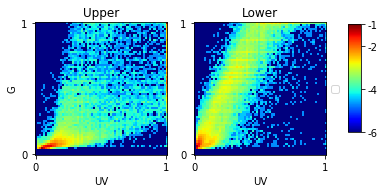

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,3))
im = axes[0].imshow(H_dview, interpolation='nearest', origin='low',cmap='jet',vmin=H_min, vmax=H_max)
axes[0].set_title('Upper')
axes[0].set_xlabel('UV'),axes[0].set_ylabel('G')
labels = ['0','1']
axes[0].set_xticks([0,63]),axes[0].set_xticklabels(labels)
axes[0].set_yticks([0,63]),axes[0].set_yticklabels(labels)
im = axes[1].imshow(H_vview, interpolation='nearest', origin='low',cmap='jet',vmin=H_min, vmax=H_max)
axes[1].set_title('Lower')
axes[1].set_xlabel('UV')
labels = ['0','1']
axes[1].set_xticks([0,63]),axes[1].set_xticklabels(labels)
axes[1].set_yticks([0,63]),axes[1].set_yticklabels(labels)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5])
ticks=[-1,-2,-4,-6]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%d")
handles, labels = axes[1].get_legend_handles_labels()
lgd = axes[1].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

### color histogram - pca

In [21]:
#exclude data get saturated or too dark
tmpind=np.where((col_all_dview[...,0]>5)&(col_all_dview[...,0]<255)&\
         (col_all_dview[...,1]>14)&(col_all_dview[...,1]<255))[0]
upper_UVG=col_all_dview[tmpind]
tmpind=np.where((col_all_vview[...,0]>5)&(col_all_vview[...,0]<255)&\
         (col_all_vview[...,1]>14)&(col_all_vview[...,1]<255))[0]
lower_UVG=col_all_vview[tmpind]

num=5000
np.random.seed(6)
temp=np.random.choice(len(upper_UVG),num,replace=False)
upper_UVG=upper_UVG[temp]
np.random.seed(66)
temp=np.random.choice(len(lower_UVG),num,replace=False)
lower_UVG=lower_UVG[temp]

upper_UVG =upper_UVG/255
lower_UVG =lower_UVG/255

In [21]:
from sklearn.decomposition import PCA
#input: X, shape (samplesize*nfeatures), should be centered, here nfeatures=2
#output: opponency index=second_eigenvalue
#      : two eigenvectors with length  (first: achromatic, second: opponent)
def pca_color_oppo(X):
    pca = PCA(n_components=2)
    pca.fit(X)
    oppo_ind=pca.explained_variance_ratio_[1]
    eigvec_achr=pca.components_[0]*pca.explained_variance_ratio_[0]
    eigvec_oppo=pca.components_[1]*pca.explained_variance_ratio_[1]
    return oppo_ind,eigvec_achr,eigvec_oppo

In [22]:
upper_oppo_ind,upper_eigvec_achr,upper_eigvec_oppo=pca_color_oppo(upper_UVG-np.mean(upper_UVG,axis=0))
lower_oppo_ind,lower_eigvec_achr,lower_eigvec_oppo=pca_color_oppo(lower_UVG-np.mean(lower_UVG,axis=0))

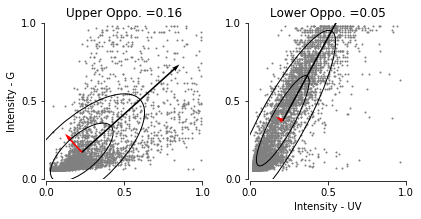

In [23]:
from matplotlib.patches import Ellipse
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(6,3))
plotdata=upper_UVG
plotmean = np.mean(plotdata, axis=0)
plotcov = np.cov(plotdata, rowvar=0)
plotlambda_, plotv = np.linalg.eig(plotcov)
plotlambda_ = np.sqrt(plotlambda_)
x_pos=[plotmean[0],plotmean[0]]
y_pos=[plotmean[1],plotmean[1]]
x_direct=[upper_eigvec_achr[0],-upper_eigvec_oppo[0]]
y_direct=[upper_eigvec_achr[1],-upper_eigvec_oppo[1]]
for ii in range(1,3):
    ellipse = Ellipse(xy=plotmean,\
    width=plotlambda_[0]*ii*2, height=plotlambda_[1]*ii*2,\
    angle=np.rad2deg(np.arccos(plotv[0, 0])),edgecolor='k', fc='None', lw=1)
    axes[0].add_patch(ellipse)
axes[0].scatter(plotdata[:,0],plotdata[:,1],s=1,color='gray',alpha=1)
axes[0].quiver(x_pos,y_pos,x_direct,y_direct,scale=1, width=0.01,color=['k','red'])
axes[0].set_aspect('equal')
axes[0].set_title('Upper Oppo. ={:.2f}'.format(upper_oppo_ind))
axes[0].set_ylabel('Intensity - G')
adjust_spines(axes[0], ['left', 'bottom'])
plotdata=lower_UVG
plotmean = np.mean(plotdata, axis=0)
plotcov = np.cov(plotdata, rowvar=0)
plotlambda_, plotv = np.linalg.eig(plotcov)
plotlambda_ = np.sqrt(plotlambda_)
x_pos=[plotmean[0],plotmean[0]]
y_pos=[plotmean[1],plotmean[1]]
x_direct=[lower_eigvec_achr[0],-lower_eigvec_oppo[0]]
y_direct=[lower_eigvec_achr[1],-lower_eigvec_oppo[1]]
for ii in range(1,3):
    ellipse = Ellipse(xy=plotmean,\
    width=plotlambda_[0]*ii*2, height=plotlambda_[1]*ii*2,\
    angle=np.rad2deg(np.arccos(plotv[0, 0])),edgecolor='k', fc='None', lw=1)
    axes[1].add_patch(ellipse)
axes[1].scatter(plotdata[:,0],plotdata[:,1],s=1,color='gray',alpha=1)
axes[1].quiver(x_pos,y_pos,x_direct,y_direct,scale=1, width=0.01,color=['k','red'])
axes[1].set_aspect('equal')
axes[1].set_title('Lower Oppo. ={:.2f}'.format(lower_oppo_ind))
axes[1].set_xlabel('Intensity - UV')
adjust_spines(axes[1], ['left', 'bottom'])
axes[0].set_xlim([0,1])
axes[0].set_ylim([0,1])
axes[1].set_xlim([0,1])
axes[1].set_ylim([0,1])
axes[0].set_xticks([0,0.5,1])
axes[1].set_xticks([0,0.5,1])
axes[0].set_yticks([0,0.5,1])
axes[1].set_yticks([0,0.5,1])
plt.tight_layout()